# Training 2d model

## Contents
* [Train process](#Train-process)
* [Data prepocessing](#Data-prepocessing)
* [Training model](#Training-model)
* [Inference](#Inference)
* [Model evaluation](#Model-evaluation)
* [Predictions](#Predictions)
    * [Worse predictions](#Worse-predictions)
    * [Best predictions](#Best-predictions)
* [Operating time](#Operating-time)
* [Summary](#Summary)

## Train process
We train our model using Adam optimizer. On each iteration we
* load batch data
* update the weights 

Loss - cross-entropy.

Dataset bypass:
* ```batch_size``` = 50

* ```n_epochs``` = 300.

In [1]:
import os
import sys
import time

from collections import defaultdict
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

sys.path.insert(0, os.path.join(".."))
from radial.batchflow import Dataset, FilesIndex, Pipeline, B, V
from radial.batchflow.models.tf import ResNet

from radial.core import RadialBatch
from radial.core.pipelines import create_train_pipeline
from radial.core.radial_batch_tools import calculate_metrics, draw_predictions

plt.style.use('ggplot')
%matplotlib inline

## Data preprocessing

Firstly you need to load the data.

In [2]:
ds_train = Dataset(FilesIndex(path="./../../../radial/research/data_splited_1/train_isol/*"), batch_class=RadialBatch)
ds_test = Dataset(FilesIndex(path="./../../../radial/research/data_splited_1/test_isol/*"), batch_class=RadialBatch)

After you should to determine the preprocessing pipeline.

In [3]:
N_SAMPLES = 100

prep_pipeline = (Pipeline().load(fmt='npz')
                    .drop_negative(src=['time', 'derivative'])
                    .to_log10(src=['time', 'derivative', 'target'])
                    .normalize(src=['time', 'derivative', 'target'],
                               src_range=[None, None, 'derivative_q'],
                               dst_range=[None, 'derivative_q', None])
                    .get_samples(N_SAMPLES, n_samples=1, sampler=np.random.random,
                                 src=['time', 'derivative'])
                    .make_points(src=['time', 'derivative'], dst=['points'])
                    .make_target(src='target')
                )

Next step is creation of config.

In [4]:
model_config = {
    'inputs': dict(points=dict(shape=(N_SAMPLES, 2)),
                   targets=dict(name='target', shape=1)),
    'initial_block/inputs': 'points',
    'head': dict(layout='f',
                 units=1),
    'body/num_blocks': [1, 1, 1],
    'body/filters': [4, 8, 16],
    'initial_block/filters': 8,
    'loss': 'mse',
    'optimizer': 'Adam'
}

## Training model

Now you finally can creae a train pipeline and run it.

In [5]:
train_pipeline = create_train_pipeline(ResNet, model_config, prep_pipeline) << ds_train

In [6]:
train_pipeline.run(50, n_epochs=300, shuffle=True, drop_last=True, bar=True)

100%|██████████| 1800/1800 [13:12<00:00,  2.29it/s]


The loss function vs number of iterations:

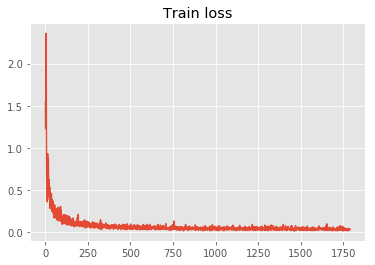

In [7]:
plt.plot(train_pipeline.get_variable('loss')[10:])
plt.title('Train loss');

## Inference

Prediction pipeline:

In [8]:
test_pipeline = prep_pipeline + (Pipeline()
                        .init_variable('predictions', init_on_each_run=list)
                        .init_variable('targets', init_on_each_run=list)
                        .import_model('model', train_pipeline)
                        .init_variable('ind', init_on_each_run=list)
                        .update_variable('ind', B('indices'), mode='e')
                        .predict_model('model', fetches='predictions',
                                                feed_dict={'points': B('points'),
                                                           'targets': B('target')},
                                        save_to=B('predictions'), mode='w')
                        .clip_values(src='predictions')
                        .denormalize(src=['predictions', 'target'], 
                                     dst=['denorm_predictions', 'denorm_target'],
                                     src_range=['derivative_q', 'derivative_q'])
                        .update_variable('predictions', B('denorm_predictions'), mode='e')
                        .update_variable('targets', B('denorm_target'), mode='e') << ds_test
)

Execute prediction pipeline.

In [9]:
test_pipeline.run(1, n_epochs=10, drop_last=True, bar=True)

100%|█████████▉| 899/900 [00:14<00:00, 61.91it/s]


## Model evaluation

Quality metric, in this case, is percentage of items with absolute percentage error less than 30% on the test set. We call it `test_mape30`

In [10]:
results = defaultdict(lambda: defaultdict(list))
for i in range(len(test_pipeline.get_variable('ind'))):
    results[test_pipeline.get_variable('ind')[i]]['pred'].append(np.ravel(test_pipeline.get_variable('predictions')[i])[0])
    results[test_pipeline.get_variable('ind')[i]]['true'] = test_pipeline.get_variable('targets')[i]
true = []
pred = []
for key in results.keys():
    results[key]['pred'] = np.mean(results[key]['pred'])
    true.append(results[key]['true'][0])
    pred.append(results[key]['pred'])

Metric evaluation:

MAE: 0.1706
MAPE: 0.1085
Percentage of error less than 30%: 95.56%


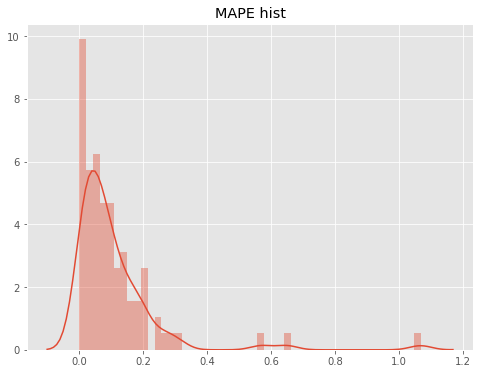

In [11]:
calculate_metrics(np.array(true), np.array(pred), 50)

## Predictions

Now let's see an examples with the biggest error value.

In [12]:
names = []
diff = []
for key, item in results.items():
    diff.append(np.abs(np.mean(item['pred']) - item['true'][0])/item['true'][0])
    names.append(key)

In [13]:
sorted_ix = np.argsort(diff)
names = np.array(names)[sorted_ix]

#### Best predictions

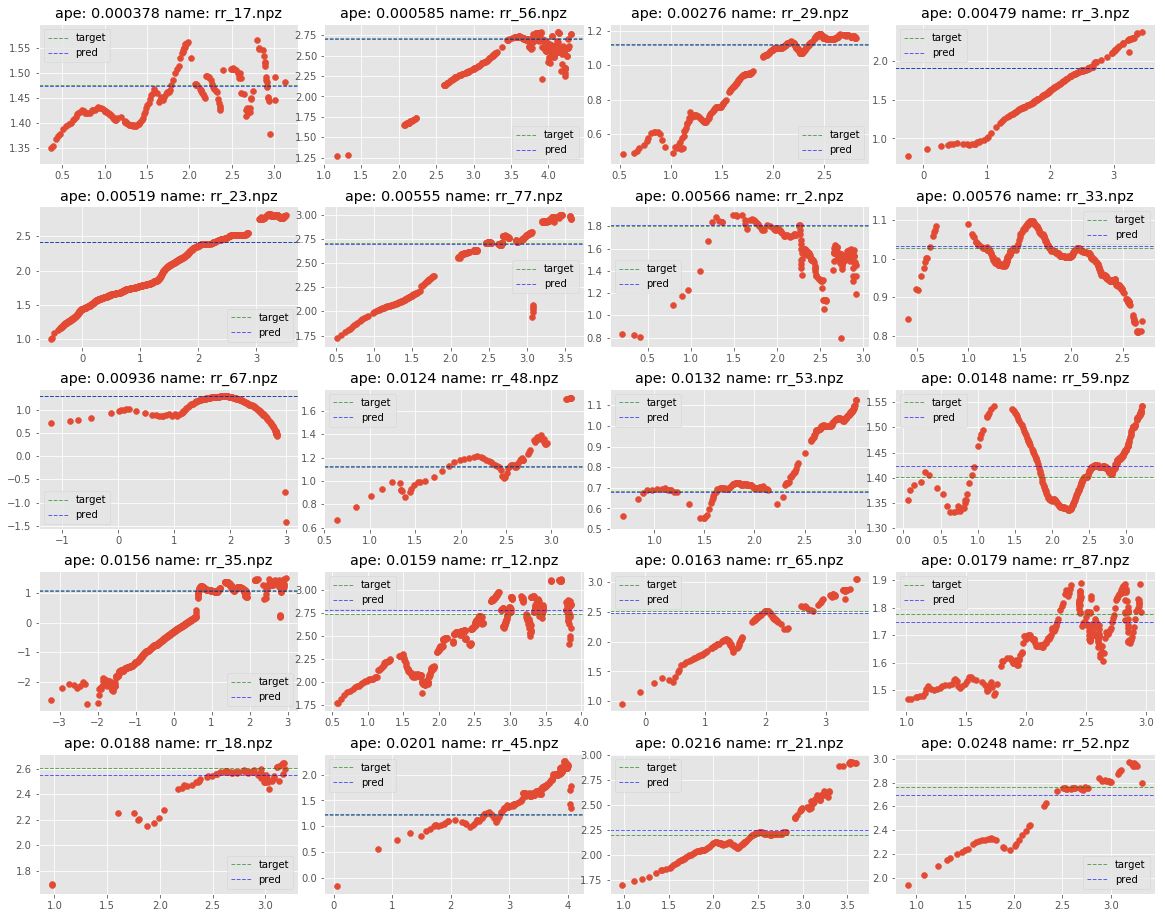

In [14]:
draw_predictions(results, names[:20], path="./../../../radial/research/data_splited_1/test_isol/")

#### Worse predictions

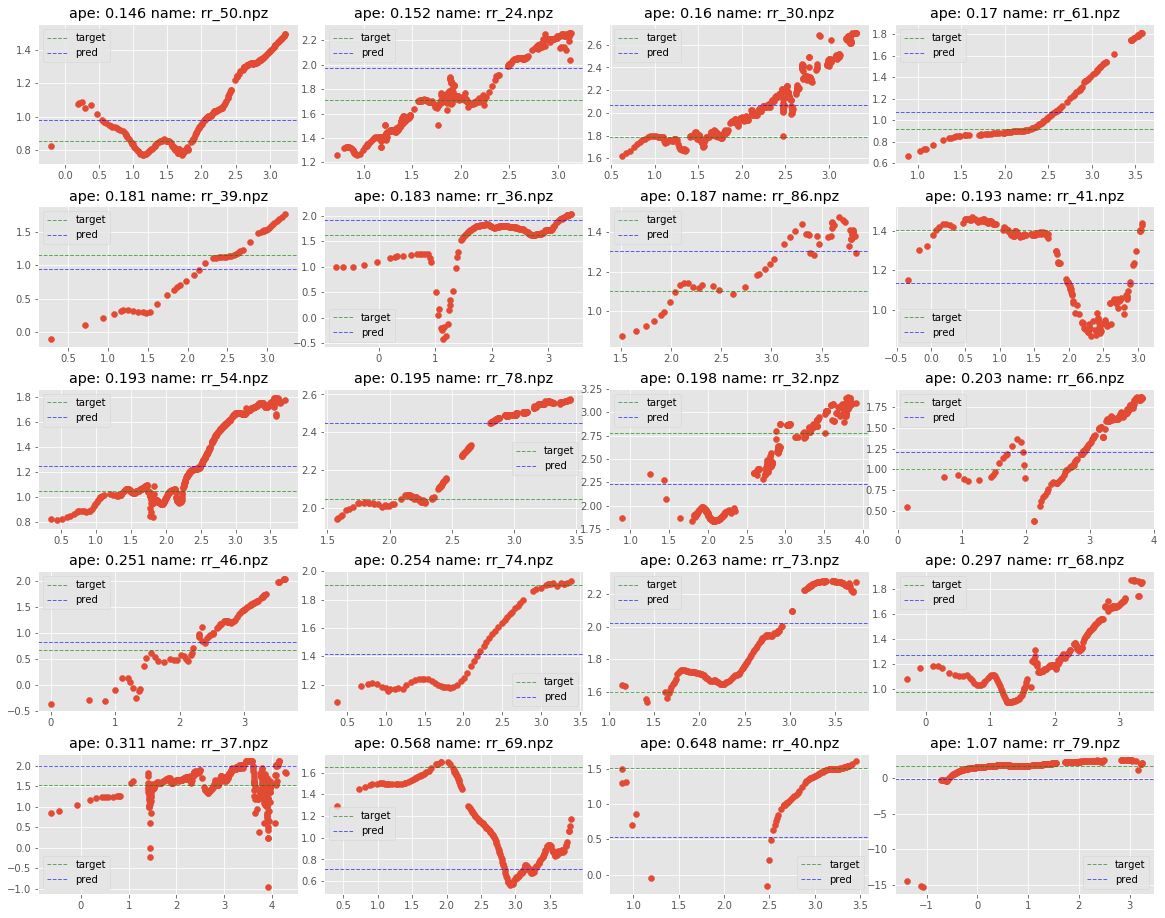

In [15]:
draw_predictions(results, names[-20:], path="./../../../radial/research/data_splited_1/test_isol/")

## Operating time

Device: GPU NVIDIA 1080.

One train step on batch size 16 takes 221 ms. Training time for 321 epochs is 393 s.

One item inference takes 23 ms, for batch size 16 - 22 ms.

In [16]:
train_pipeline.reset_iter()

start_time = time.clock()
train_pipeline.next_batch(16)
print(time.clock() - start_time)

0.21661900000003698


In [17]:
start_time = time.clock()
for i in range(2000):
    train_pipeline.next_batch(50, n_epochs=None, drop_last=True, shuffle=True)
print(time.clock() - start_time)

1058.926873


In [18]:
test_pipeline.reset_iter()
start_time = time.clock()
test_pipeline.next_batch(1)
print(time.clock() - start_time)

0.023836000000301283


In [19]:
test_pipeline.reset_iter()
start_time = time.clock()
test_pipeline.next_batch(16)
print(time.clock() - start_time)

0.2278479999999945


## Summary

The model predicts a position of the radial mode according to the pressure derivative vs time data. The mean model metrics corresponding to a percentage of items with absolute percentage error less than 30% is 95.5%